In [34]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [35]:
import sys
sys.path.append('../')

In [36]:
from solution.dicom_utils import Patient
from solution.plots import save_images, show_img_msk_fromarray
from solution.dataset import HeartDataset2D
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2

### Create Patients/Studies

Let's use the code from part 1 to parse contour-i and contour-o for any given patient that we have in our study. We don't need to change anything for extracting contour-o since all Patient objects will have all associated information: image, contour-i and contour-o.

In [38]:
# get path objects
data = list(Path('../final_data/').iterdir())

In [39]:
data

[PosixPath('../final_data/dicoms'),
 PosixPath('../final_data/images'),
 PosixPath('../final_data/contourfiles'),
 PosixPath('../final_data/link.csv')]

In [40]:
# read link.csv
links = pd.read_csv(data[-1])

# rename dataframe columns for explicity
links = links.rename(columns={'patient_id':'dicoms', 'original_id':'contourfiles'})

# create link pairs of dicom_id anf contourfiles_id
link_pairs = list(zip(links['dicoms'], links['contourfiles']))

In [41]:
link_pairs

[('SCD0000101', 'SC-HF-I-1'),
 ('SCD0000201', 'SC-HF-I-2'),
 ('SCD0000301', 'SC-HF-I-4'),
 ('SCD0000401', 'SC-HF-I-5'),
 ('SCD0000501', 'SC-HF-I-6')]

In [42]:
# initialize Patient objects for each link
patients = []
for dicom_id, contour_id in link_pairs:
    patient = Patient(dicom_id=dicom_id, contour_id=contour_id, dicoms_path=data[0], contourfiles_path=data[2])
    patients.append(patient)

In [43]:
patients

## Part 1 - Parse o-contours

In [44]:
for patient in patients:
    patient.create_numpy_arrays()

# of dicoms : 480i_contours : 36,o_contours : 18
# of valid dicoms : 240,i_contours :18,o_contours : 9
# of dicoms : 520i_contours : 36,o_contours : 18
# of valid dicoms : 260,i_contours :18,o_contours : 9
# of dicoms : 400i_contours : 40,o_contours : 20
# of valid dicoms : 200,i_contours :20,o_contours : 10
# of dicoms : 440i_contours : 36,o_contours : 18
# of valid dicoms : 220,i_contours :18,o_contours : 9
# of dicoms : 440i_contours : 44,o_contours : 18
# of valid dicoms : 220,i_contours :22,o_contours : 9


In [45]:
patients[0].all_numpy_dict

{1: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 2: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 3: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 4: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

## Part 2: Heuristic LV Segmentation approaches

In [46]:
patient0 = patients[0]

In [47]:
# extract if both contours are present
contour_slices = []
for slice_no in patient0.all_numpy_dict:
    slice_dict = patient0.all_numpy_dict[slice_no]
    if (slice_dict['o_contour_array'] is not None) & (slice_dict['i_contour_array'] is not None):
        contour_slices.append(slice_no)

In [48]:
contour_slices

[219, 99, 119, 179, 79, 59, 139, 159, 199]

In [49]:
# example slice contour arrays
slice_idx = 6
slice_no = contour_slices[slice_idx]
dicom_array = patient0.all_numpy_dict[slice_no]['dicom_array']
i_contour_array = patient0.all_numpy_dict[slice_no]['i_contour_array']
o_contour_array = patient0.all_numpy_dict[slice_no]['o_contour_array']

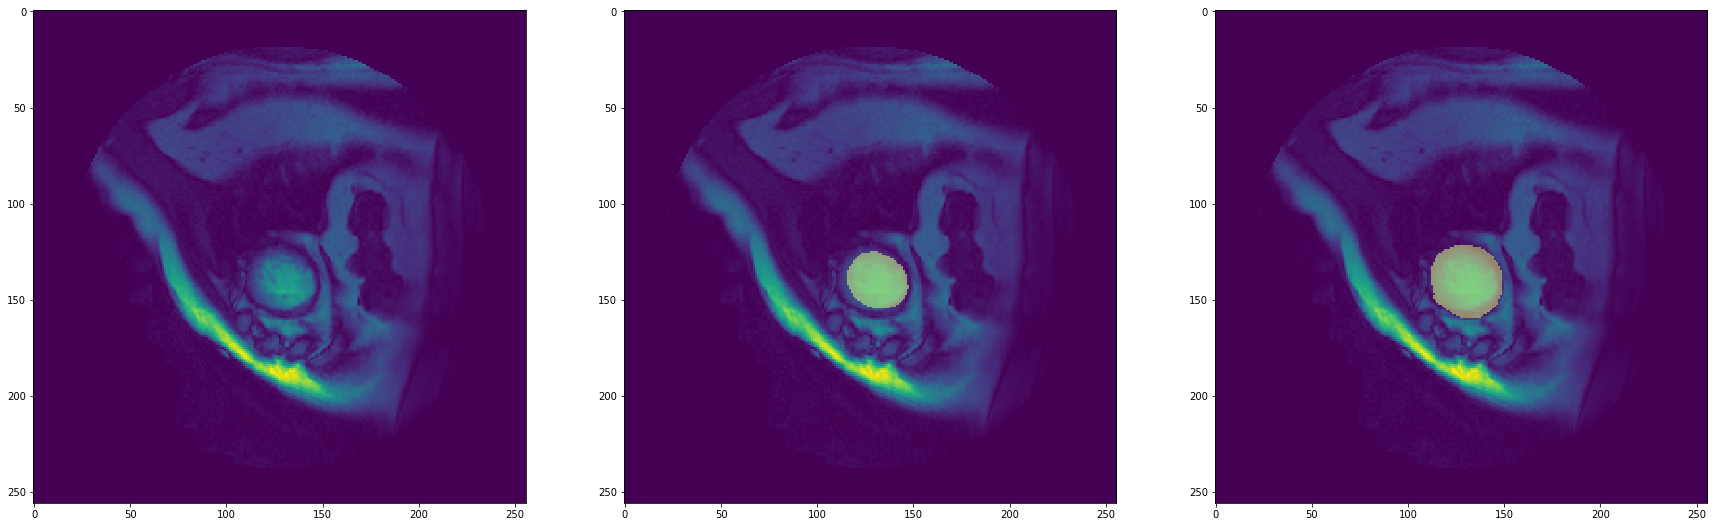

In [75]:
sz = 30
cmap="Wistia"
alpha=0.5
plt.figure(figsize=(sz, sz))

# raw image
plt.subplot(1, 3, 1)
plt.imshow(dicom_array)

# i-contour 
plt.subplot(1, 3, 2)
plt.imshow(dicom_array)
mask_arr = np.ma.masked_where(i_contour_array == 0, i_contour_array)
plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

# o-contour 
plt.subplot(1, 3, 3)
plt.imshow(dicom_array)
mask_arr = np.ma.masked_where(o_contour_array == 0, o_contour_array)
plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

(array([51932.,  7187.,  3678.,  1102.,   576.,   393.,   238.,   199.,
          150.,    81.]),
 array([  0. ,  77.9, 155.8, 233.7, 311.6, 389.5, 467.4, 545.3, 623.2,
        701.1, 779. ]),
 <a list of 10 Patch objects>)

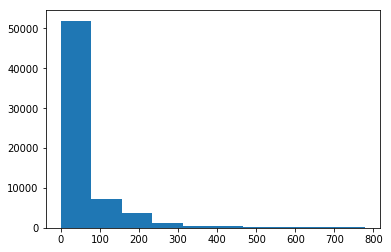

In [76]:
plt.hist(dicom_array.flatten())

In [77]:
def show_all_masks(dicom_array, i_contour_array, o_contour_array):
    sz = 30
    cmap="Wistia"
    alpha=0.5
    plt.figure(figsize=(sz, sz))

    # raw image
    plt.subplot(1, 3, 1)
    plt.imshow(dicom_array)

    # i-contour 
    plt.subplot(1, 3, 2)
    plt.imshow(dicom_array)
    mask_arr = np.ma.masked_where(i_contour_array == 0, i_contour_array)
    plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

    # o-contour 
    plt.subplot(1, 3, 3)
    plt.imshow(dicom_array)
    mask_arr = np.ma.masked_where(o_contour_array == 0, o_contour_array)
    plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

### Heuristic Approach 1: Simple Thresholding + Morphological Ops

By using contour-o try to generate contour-i with thresholding.

**1)** Take pixels inside contour-o.

**2)** Try different thresholds which will maximize the dice score with ground truth.

**3)** Apply morphological operations to increase the score.

**3)** Talk about advantages and disadvantages of the approach.


**Advantage**

- Easy to implement
- Faster than neural net inference time
- Gives good results


**Disadvantage**

Are intensity distributions are same for each image across all slices and all patients/studies ? If not problem ! We saw that it's a problem - a boxplot is provided for this analysis.

- Very manual task
- Depends on many assumptions such as pixel intensity distributions being similar between and within images
- Needs post-processing
- Hard to tune for threshold and morphological operation orders/parameters
- Picking the threshold is very hard, variance is too high -> normalization + clustering ?

In [78]:
def dice_score(pred, targ):
    """
    Sorensen dice score:
    https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

    pred (np.array): prediction boolean mask
    targ (np.array): target boolean mask
    """
    pred = pred.flatten()
    targ = targ.flatten()
    return 2 * sum(pred * targ) / (sum(pred) + sum(targ))

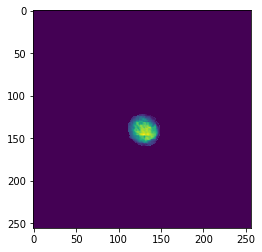

In [79]:
# get roi array by using o-contour
roi_array = dicom_array * o_contour_array
plt.imshow(roi_array)

(array([125., 162., 133., 111.,  97.,  95., 145., 128., 130.,  16.]),
 array([ 16. ,  63.3, 110.6, 157.9, 205.2, 252.5, 299.8, 347.1, 394.4,
        441.7, 489. ]),
 <a list of 10 Patch objects>)

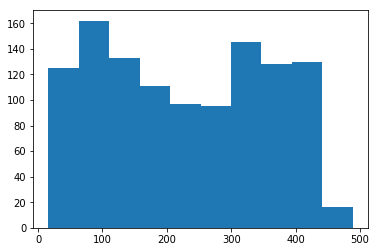

In [80]:
# check intensities
# almost a bimodal distribution
# we can split it into two separate parts
plt.hist(roi_array[roi_array != 0])

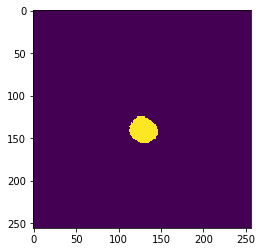

In [81]:
# try thresholding
threshold = 130
roi_i_contour_proposal = (roi_array > threshold)
plt.imshow(roi_i_contour_proposal)

In [82]:
# seems good 
dice_score(roi_i_contour_proposal, i_contour_array)

0.9148099606815203

In [83]:
# morpholigical closing
# create the kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# set dtype correct for OpenCV
roi_i_contour_proposal = roi_i_contour_proposal.astype(np.uint8)
# apply closing
roi_i_contour_proposal_closed = cv2.morphologyEx(roi_i_contour_proposal, cv2.MORPH_CLOSE, kernel)

In [84]:
# better 
dice_score(roi_i_contour_proposal_closed, i_contour_array)

0.9149214659685864

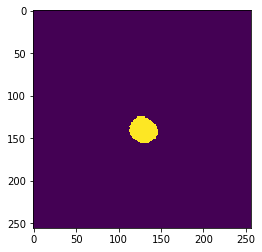

In [85]:
plt.imshow(roi_i_contour_proposal_closed)

In [86]:
# morpholigical opening
# create the kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# apply closing
roi_i_contour_proposal_final = cv2.morphologyEx(roi_i_contour_proposal_closed, cv2.MORPH_OPEN, kernel)

In [87]:
# even better
dice_score(roi_i_contour_proposal_final, i_contour_array)

0.9155206286836935

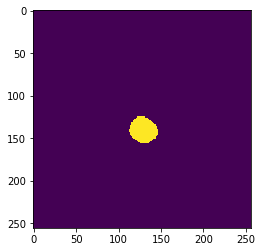

In [88]:
plt.imshow(roi_i_contour_proposal_final)

In [89]:
# define kernel types
KERNEL_TYPE = [
    cv2.MORPH_RECT,
    cv2.MORPH_ELLIPSE,
    cv2.MORPH_CROSS,
]

In [90]:
def i_contour_from_o_contour(dicom_array, o_contour_array, threshold = 130,
                            kernel_type=0, kernel_sz=3):
    """
    Generate i-contour given a o-contour array
    by employing thresholding and morphological
    operations. Applies closing -> opening -> final proposal
    
    Inputs:
        dicom_array (np.array): Raw DICOM image
        o_contour_array (np.array): Boolean mask array
            for o-contour
        threshold (int): threshold for i-contour
            extraction. 
        kernel_type (int, list): 0: cv2.MORPH_RECT
                                 1: cv2.MORPH_ELLIPSE
                                 2: cv2.MORPH_CROSS
            If list, it must have 2 elements:
            one for opening, one for closing.
        kernel_size (int, list): kernel size for operations
            If list, it must have 2 elements:
            one for opening, one for closing
    Return:
        i_contour_proposal (np.array): Proposed boolean
        mask array for i-contour
    """
    #pdb.set_trace()

    if isinstance(kernel_type, list) & isinstance(kernel_sz, list):
        kernel_type1, kernel_type2 = kernel_type
        kernel_sz1, kernel_sz2 = kernel_sz
        
    elif isinstance(kernel_type, int) & isinstance(kernel_sz, int):
        kernel_type1, kernel_type2 = kernel_type, kernel_type
        kernel_sz1, kernel_sz2 = kernel_sz, kernel_sz
    else:
        raise Exception('kernel_type and kernel_sz must be both int or list')
    
    roi_array = dicom_array * o_contour_array    
    roi_i_contour_proposal = (roi_array > threshold).astype(np.uint8)

    # apply closing
    kernel = cv2.getStructuringElement(KERNEL_TYPE[kernel_type1],
                                       (kernel_sz1, kernel_sz1))
    roi_i_contour_proposal = cv2.morphologyEx(roi_i_contour_proposal,
                                                     cv2.MORPH_CLOSE, kernel)
    # apply opening
    kernel = cv2.getStructuringElement(KERNEL_TYPE[kernel_type2],
                                       (kernel_sz2, kernel_sz2))
    roi_i_contour_proposal = cv2.morphologyEx(roi_i_contour_proposal,
                                                    cv2.MORPH_OPEN, kernel)

    return roi_i_contour_proposal

In [91]:
proposal = i_contour_from_o_contour(dicom_array, o_contour_array, 130, kernel_type=0, kernel_sz=3)

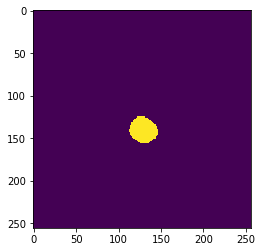

In [92]:
plt.imshow(proposal)

### Pipeline for i-contour heuristic generation

In [104]:
patient0 = patients[0]

In [105]:
def extract_all_mask_slices(patient):
    """
    For a given patient object extract slice idx
    list where all arrays are present, both
    i_contour_array and o_contour_array
    
    Inputs:
        patient (Patient object): patient object
    """
    # generate numpy arrays for the patient
    if not hasattr(patient, "all_numpy_dict"):
        patient.create_numpy_arrays(False)
        
    contour_slices = []
    for slice_no in patient.all_numpy_dict:
        slice_dict = patient.all_numpy_dict[slice_no]
        if (slice_dict['o_contour_array'] is not None) & (slice_dict['i_contour_array'] is not None):
            contour_slices.append(slice_no)
    return contour_slices

In [106]:
# extracting mask slice idxs for patient 
all_mask_slice_idxs = extract_all_mask_slices(patient0)

In [107]:
def extract_patient_arrays(patient, slice_idx):
    """
    Extract dicom_array, i_contour_array, o_contour_array
    from patient all_numpy_dict 
    
    Inputs:
        patient (Patient object): patient object
        slice_idx (int): slice index for array extraction
    """
    dicom_array = patient.all_numpy_dict[slice_idx]['dicom_array']
    i_contour_array = patient.all_numpy_dict[slice_idx]['i_contour_array']
    o_contour_array = patient.all_numpy_dict[slice_idx]['o_contour_array']
    return dicom_array, i_contour_array, o_contour_array

In [108]:
# check first slice
dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient0, all_mask_slice_idxs[0])
proposal = i_contour_from_o_contour(dicom_array, o_contour_array, 100)
dice_score(proposal, i_contour_array)

0.9310344827586207

***Here we define baseline as the score we would get if we just predict i-contour as o-contour. This will allow us to see how much better we can do with heuristic approaches.***

In [109]:
# baseline : if we don't do any heuristics but take i-contour same as o-contour
print(f"Baseline dice score: {round(dice_score(o_contour_array, i_contour_array), 3)}")

Baseline dice score: 0.748


**Check all slices for this patient**

In [110]:
# do for all slice idxs
dice_scores = []
baseline_scores = []

for all_mask_slice_idx in all_mask_slice_idxs:
    dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient0, all_mask_slice_idx)
    proposal = i_contour_from_o_contour(dicom_array, o_contour_array, 100)
    dice = round(dice_score(proposal, i_contour_array), 3)
    baseline = round(dice_score(o_contour_array, i_contour_array), 3)
    print(f"Slice {all_mask_slice_idx} Dice Score {dice}")
    dice_scores.append(dice)
    baseline_scores.append(baseline)
print()
print(f"Mean: {round(np.mean(dice_scores),3)}, Std: {round(np.std(dice_scores),2)}")
print(f"Mean: {round(np.mean(baseline_scores),3)}, Std: {round(np.std(baseline_scores),2)}")

Slice 219 Dice Score 0.931
Slice 99 Dice Score 0.903
Slice 119 Dice Score 0.877
Slice 179 Dice Score 0.827
Slice 79 Dice Score 0.909
Slice 59 Dice Score 0.913
Slice 139 Dice Score 0.879
Slice 159 Dice Score 0.829
Slice 199 Dice Score 0.887

Mean: 0.884, Std: 0.03
Mean: 0.768, Std: 0.02


Text(0.5,1,'Patient 0')

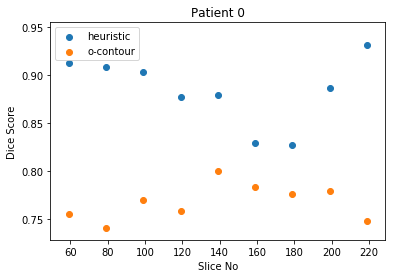

In [111]:
l1 = plt.scatter(all_mask_slice_idxs, dice_scores)
l2 = plt.scatter(all_mask_slice_idxs, baseline_scores)
plt.legend((l1, l2), ("heuristic", "o-contour"))
plt.xlabel("Slice No")
plt.ylabel("Dice Score")
plt.title("Patient 0")

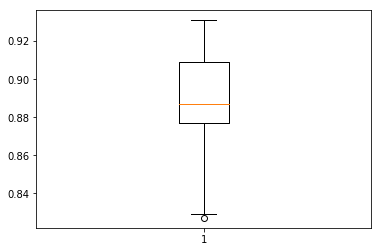

In [43]:
fig, ax = plt.subplots()
ax = ax.boxplot(dice_scores)

In [113]:
# within low scoring slice
dicom_bad, i_bad, o_bad = extract_patient_arrays(patient0, 179)

In [114]:
def show_all_masks(dicom_array, i_contour_array, o_contour_array,
                  sz=30, cmap='Wistia', alpha=0.5):
    """
    Plot raw image, raw image with i-contour and raw image with o-contour
    """
    plt.figure(figsize=(sz, sz))

    # raw image
    plt.subplot(1, 3, 1)
    plt.imshow(dicom_array)

    # i-contour 
    plt.subplot(1, 3, 2)
    plt.imshow(dicom_array)
    mask_arr = np.ma.masked_where(i_contour_array == 0, i_contour_array)
    plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

    # o-contour 
    plt.subplot(1, 3, 3)
    plt.imshow(dicom_array)
    mask_arr = np.ma.masked_where(o_contour_array == 0, o_contour_array)
    plt.imshow(mask_arr, cmap=cmap, alpha=alpha)

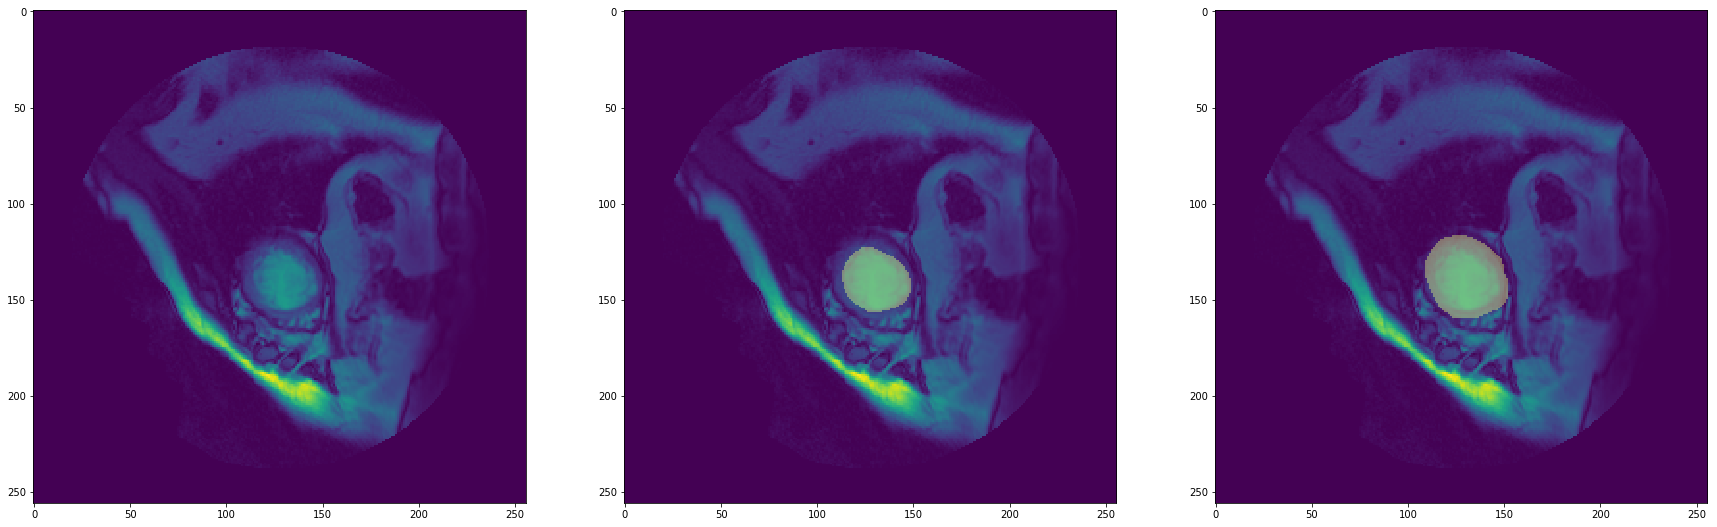

In [115]:
# when intensity is low 
# single value thresholding performs bad
show_all_masks(dicom_bad, i_bad, o_bad, alpha=0.4)

### Score all patients

Heuristic approach 1 is very incosistent. We can see 2 major problems of simple thresholding causing bad performance:

- Intensity differences between slices (within study)
  
  **Example:** Patient 1 slices: 200, 220 have low scores compared to other slices. Outliers are seen the boxplot below.

- Intensity differences between patient images (between study)

    **Example:** Patient 4 have low scores compared to other patients/studies. Boxplot shows difference of Patient 4 relative to other patients.

In [118]:
all_dice_scores = []
all_baseline_scores = []
patient_ids = []

for i, patient in enumerate(patients):
    print(f"Patient {i}")
    # extracting mask slice idxs for patient 
    all_mask_slice_idxs = sorted(extract_all_mask_slices(patient))
    
    dice_scores = []
    baseline_scores = []
    for all_mask_slice_idx in all_mask_slice_idxs:
        # extract slices with all arrays
        dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, all_mask_slice_idx)
        # generate proposal
        proposal = i_contour_from_o_contour(dicom_array=dicom_array,
                                            o_contour_array=o_contour_array,
                                            threshold=130,
                                            kernel_type=0,
                                            kernel_sz=3
                                           )
        # calculate dice and baseline scores
        dice = round(dice_score(proposal, i_contour_array), 3)
        baseline = round(dice_score(o_contour_array, i_contour_array), 3)
        # print it
        print(f"Slice {all_mask_slice_idx} Dice Score {dice}")
        dice_scores.append(dice)
        baseline_scores.append(baseline)
    # print stats
    print()
    print(f"Dice Mean: {round(np.mean(dice_scores),3)}, Std: {round(np.std(dice_scores),2)}")
    print(f"Baseline Mean: {round(np.mean(baseline_scores),3)}, Std: {round(np.std(baseline_scores),2)}")
    print()
    # collect all 
    all_dice_scores.append(dice_scores)
    all_baseline_scores.append(baseline_scores)
    patient_ids.append([i]*len(dice_scores))

Patient 0
Slice 59 Dice Score 0.949
Slice 79 Dice Score 0.956
Slice 99 Dice Score 0.956
Slice 119 Dice Score 0.912
Slice 139 Dice Score 0.894
Slice 159 Dice Score 0.865
Slice 179 Dice Score 0.876
Slice 199 Dice Score 0.916
Slice 219 Dice Score 0.86

Dice Mean: 0.909, Std: 0.04
Baseline Mean: 0.768, Std: 0.02

Patient 1
Slice 60 Dice Score 0.947
Slice 80 Dice Score 0.936
Slice 100 Dice Score 0.908
Slice 120 Dice Score 0.838
Slice 140 Dice Score 0.879
Slice 160 Dice Score 0.851
Slice 180 Dice Score 0.814
Slice 200 Dice Score 0.683
Slice 220 Dice Score 0.416

Dice Mean: 0.808, Std: 0.16
Baseline Mean: 0.722, Std: 0.14

Patient 2
Slice 20 Dice Score 0.868
Slice 40 Dice Score 0.818
Slice 60 Dice Score 0.822
Slice 80 Dice Score 0.844
Slice 100 Dice Score 0.877
Slice 120 Dice Score 0.867
Slice 140 Dice Score 0.896
Slice 160 Dice Score 0.917
Slice 180 Dice Score 0.899
Slice 200 Dice Score 0.835

Dice Mean: 0.864, Std: 0.03
Baseline Mean: 0.768, Std: 0.05

Patient 3
Slice 40 Dice Score 0.891
Sl

In [119]:
# prepare summary dataframe for plotting
n = len([y for x in all_baseline_scores for y in x])
summary = pd.DataFrame({"scores":np.hstack(all_dice_scores + all_baseline_scores),
              "id":np.hstack(patient_ids + patient_ids),
              "method":n*["heuristic"] + n*["baseline"]})

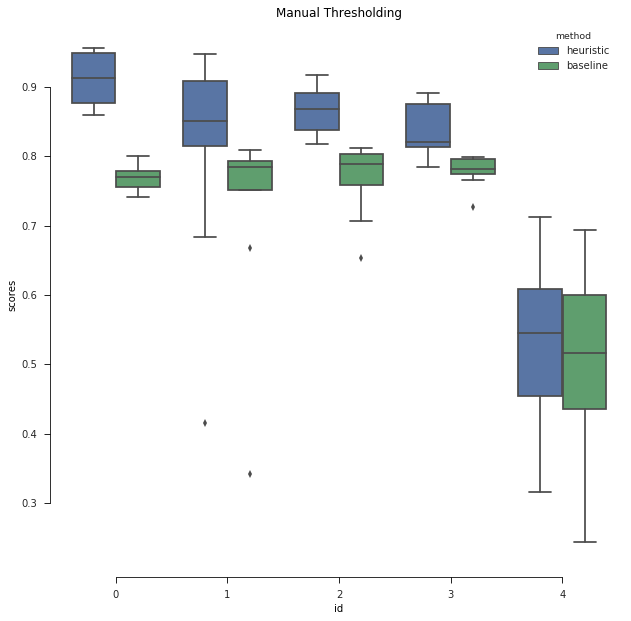

In [120]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('Patient Id')
plt.ylabel('Dice Score')

sns.set(style="ticks")
sns.boxplot(x="id", y="scores", hue="method", data=summary, ax=ax)
sns.despine(offset=10, trim=True)
t = plt.title("Manual Thresholding")

In [121]:
heuristic1_res = summary

In [122]:
heuristic1_res.head()

,id,method,scores
0,0,heuristic,0.949
1,0,heuristic,0.956
2,0,heuristic,0.956
3,0,heuristic,0.912
4,0,heuristic,0.894


In [123]:
heuristic1_res.groupby('method')['scores'].agg({'mean':np.mean, 'std':np.std})

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,mean,std
method,,
baseline,0.707848,0.144136
heuristic,0.790543,0.167922


### Inspect Cases: Patient 1 and 4

In [54]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

#### Patient 1

In [55]:
patient = patients[1]

In [56]:
slice_idxs = sorted(extract_all_mask_slices(patient))

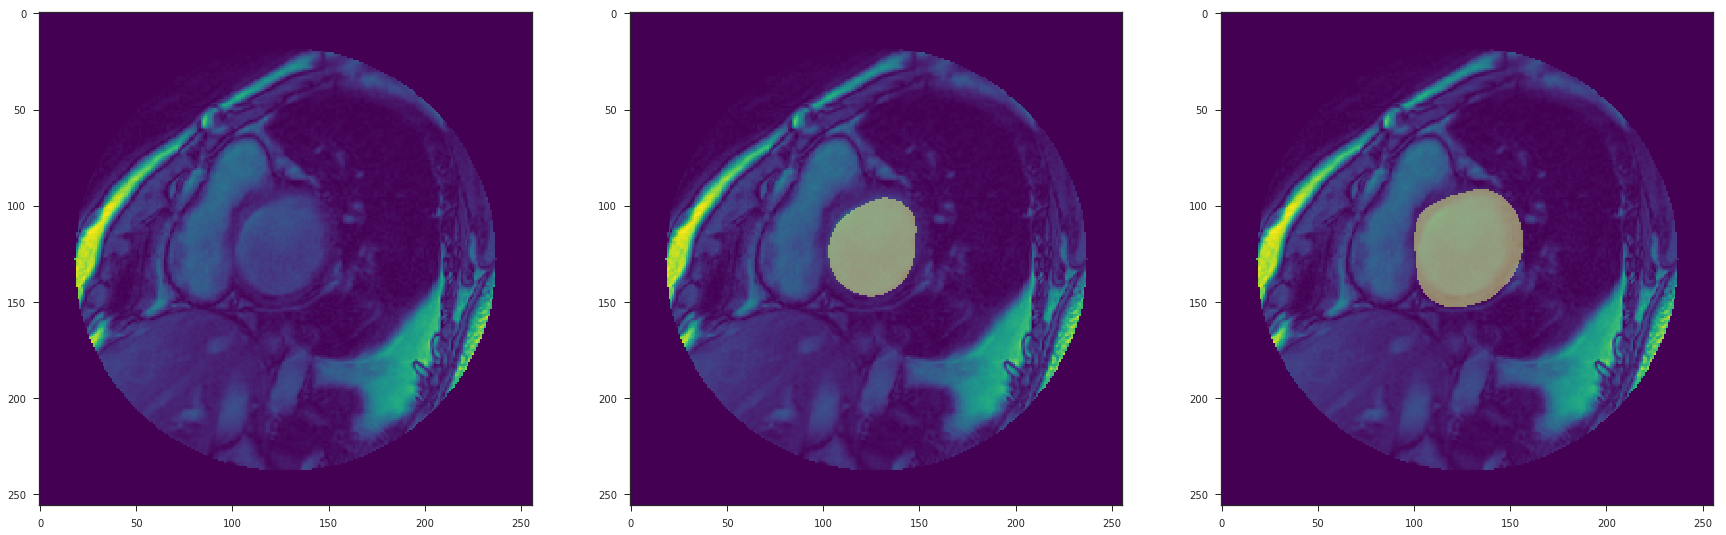

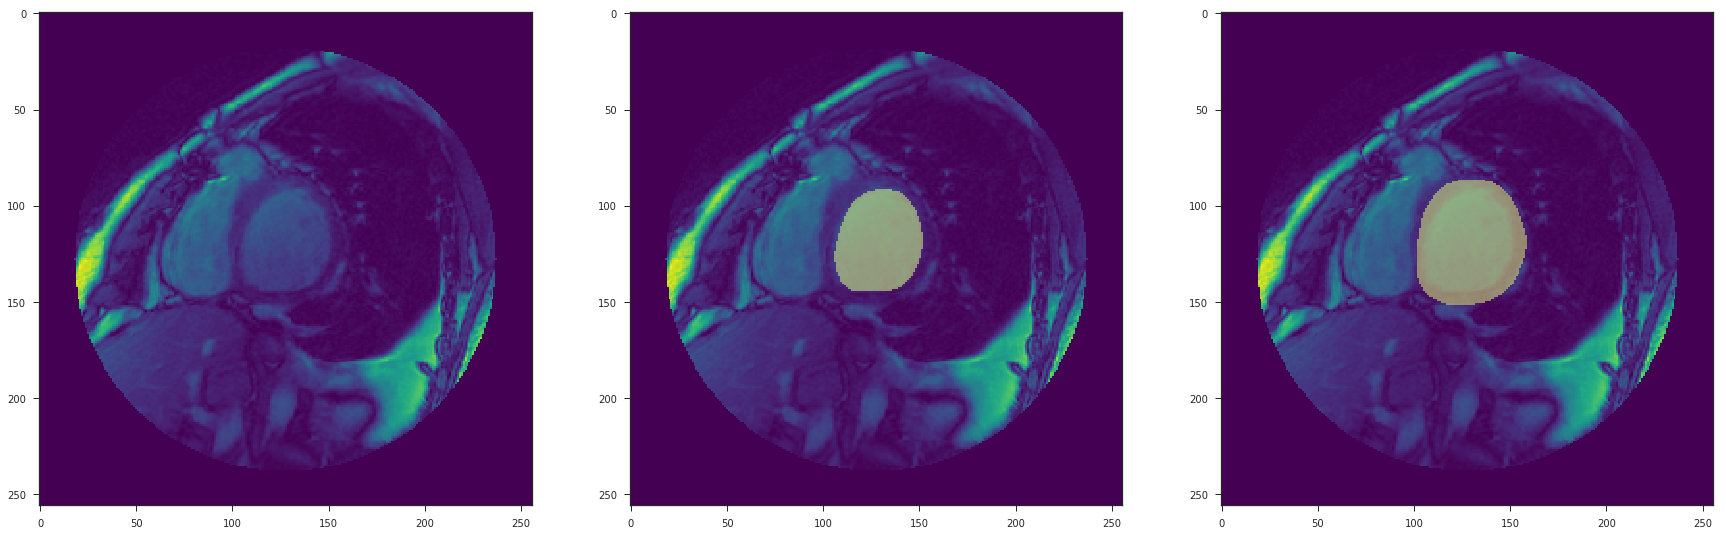

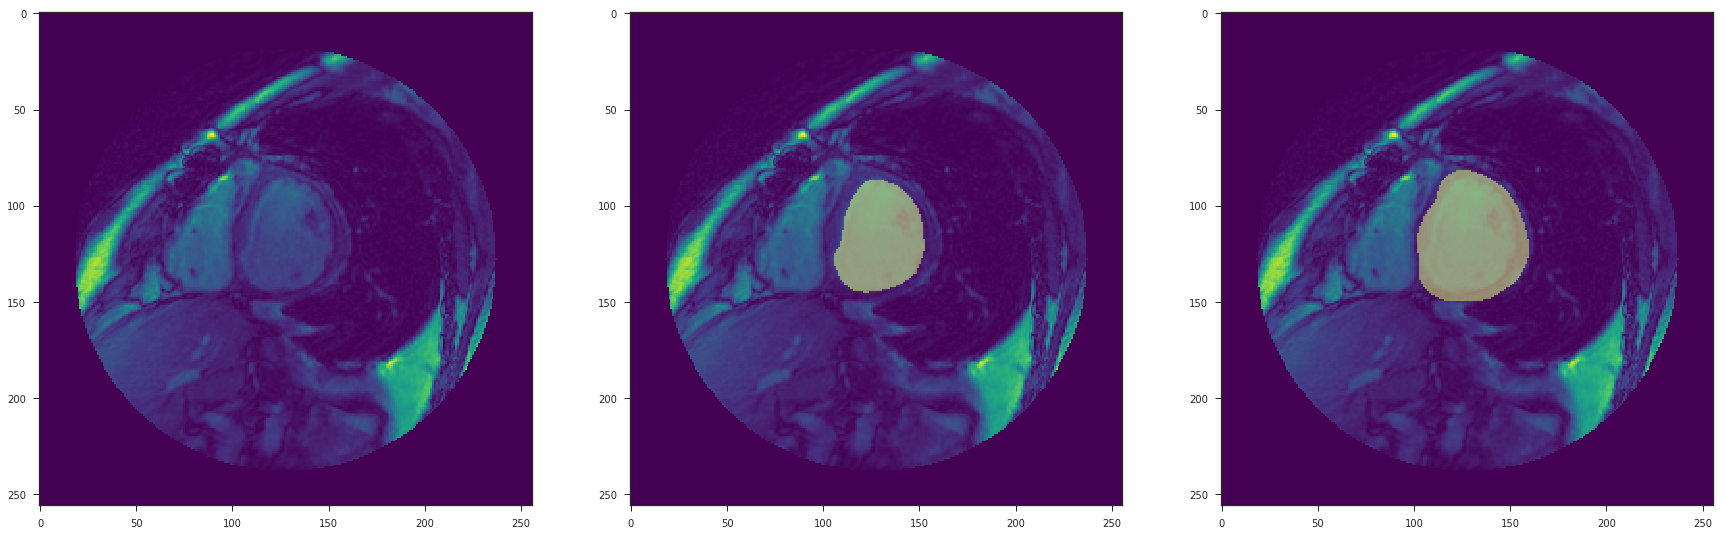

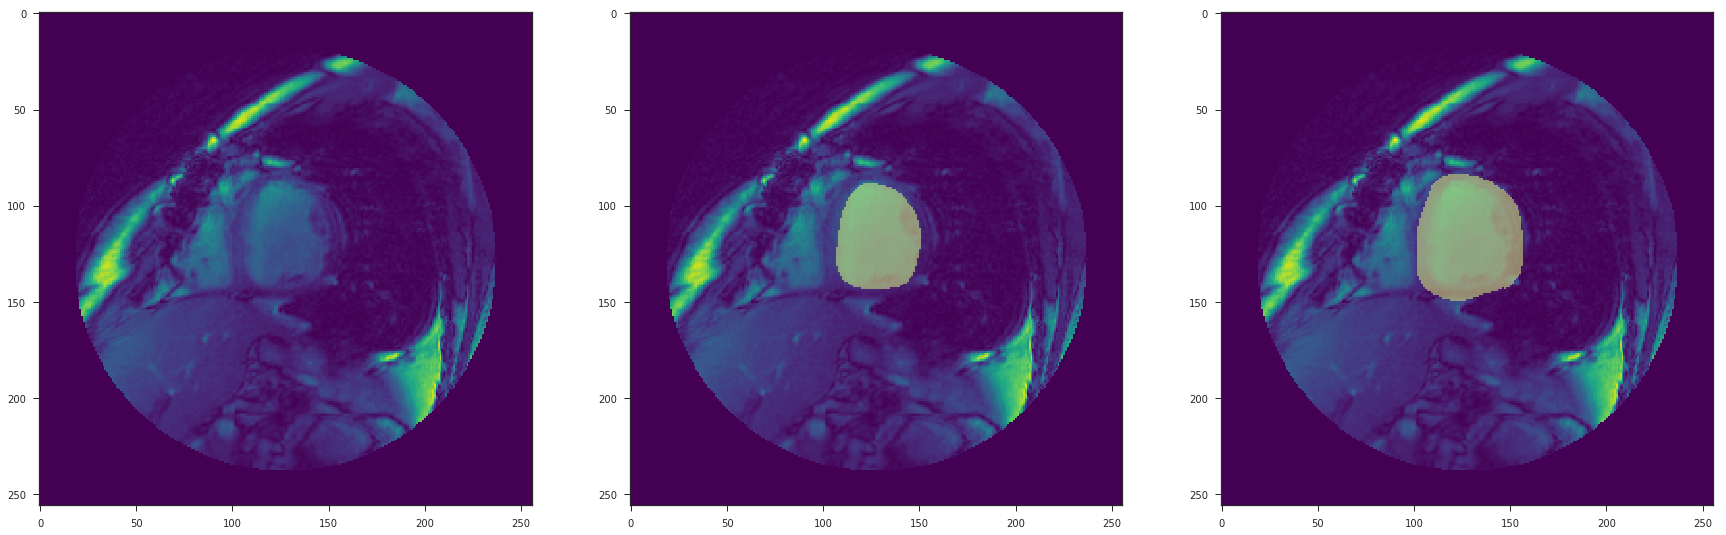

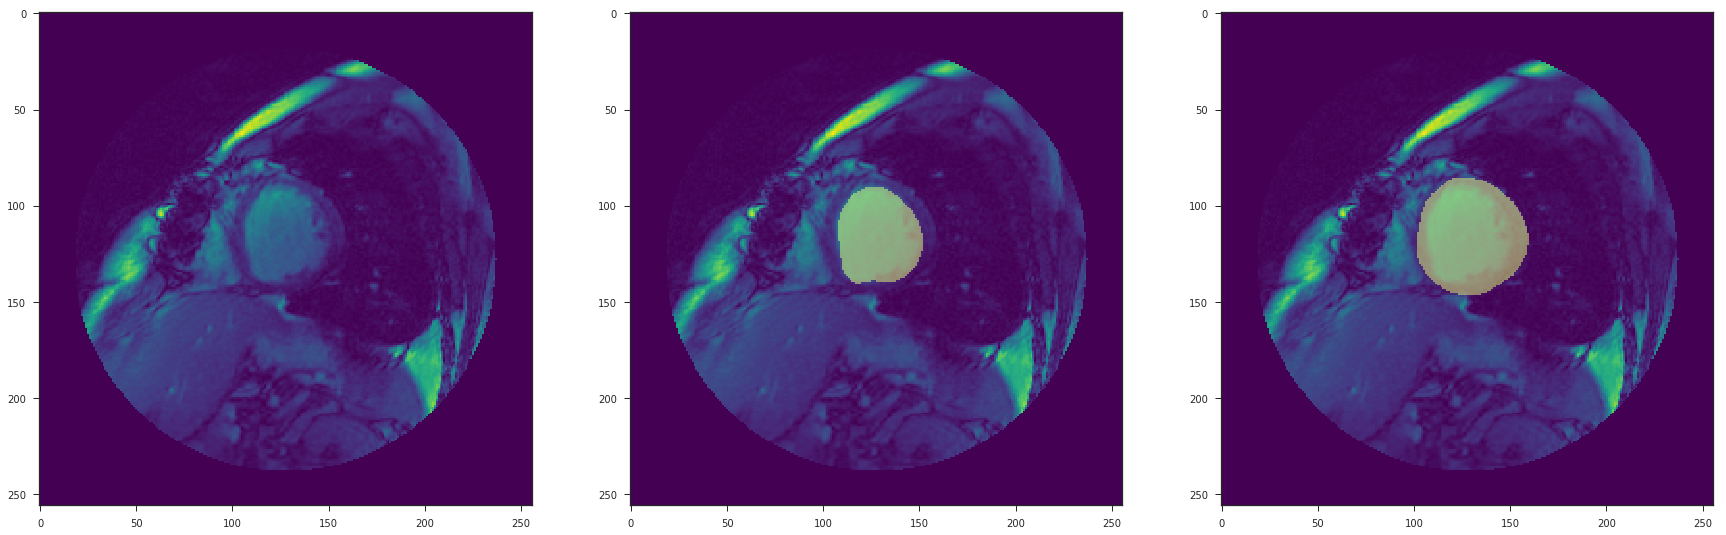

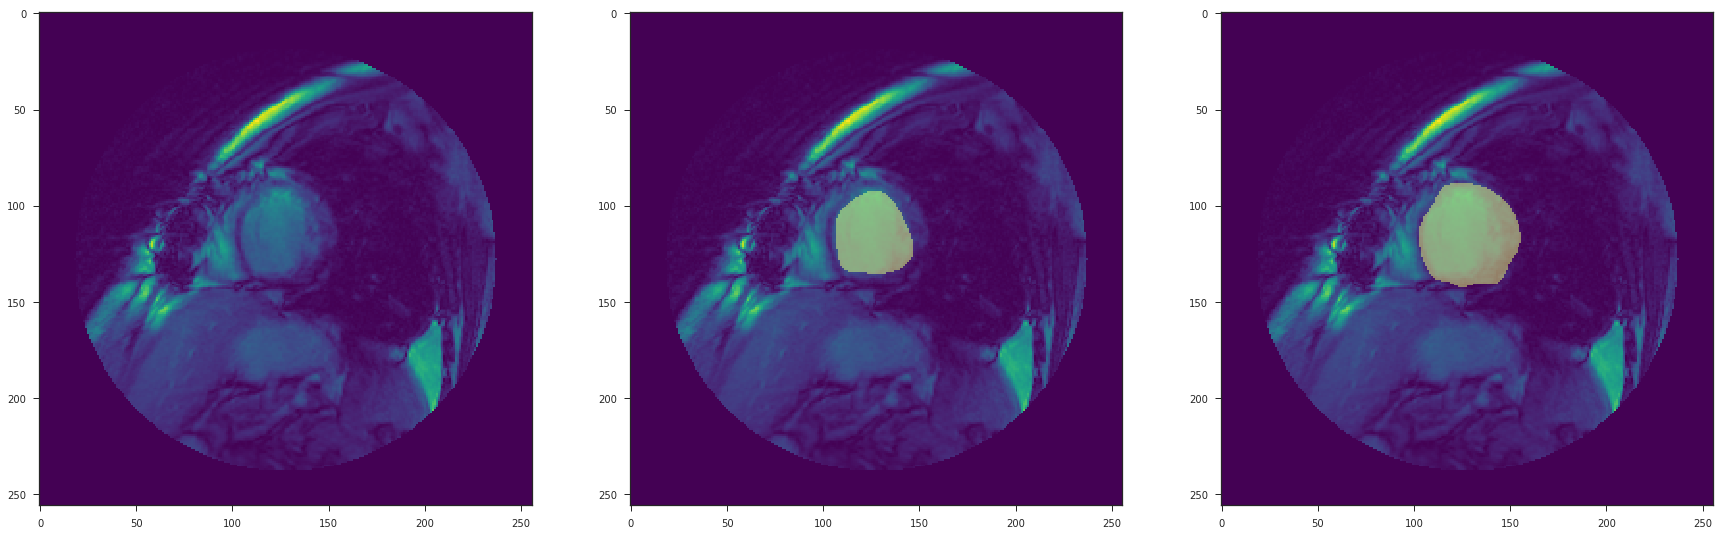

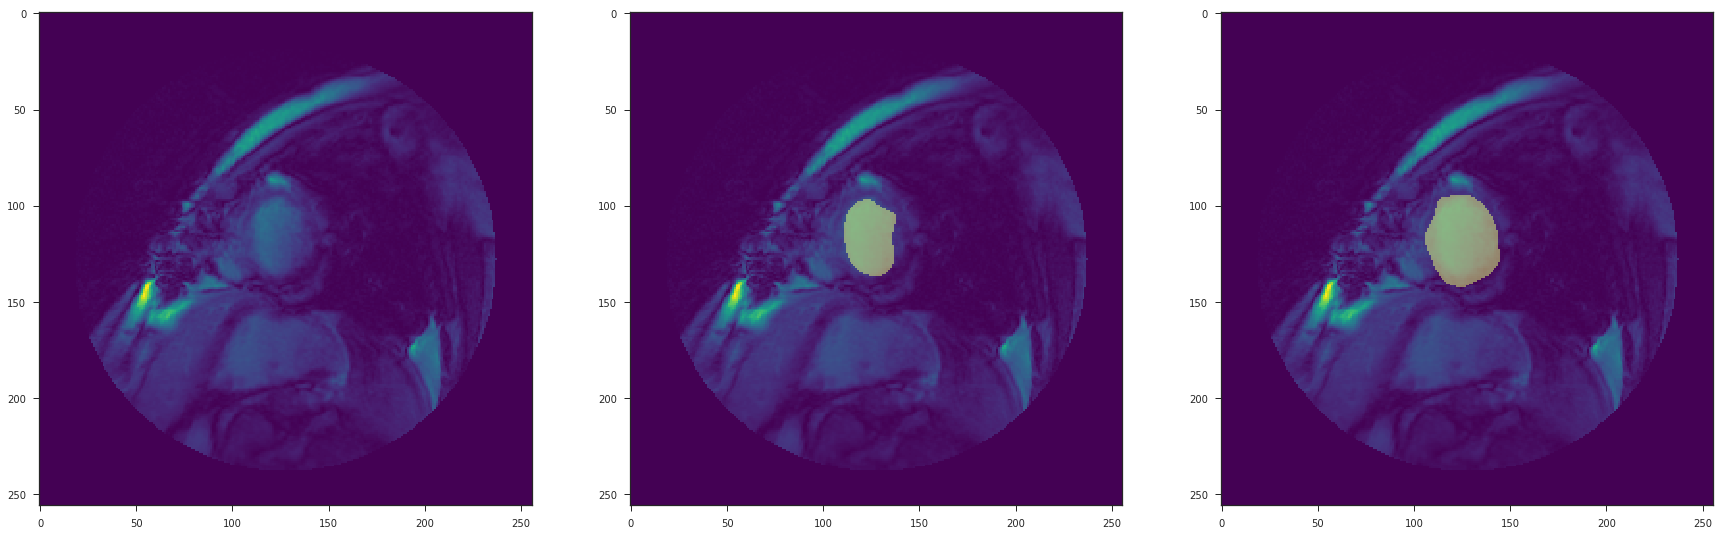

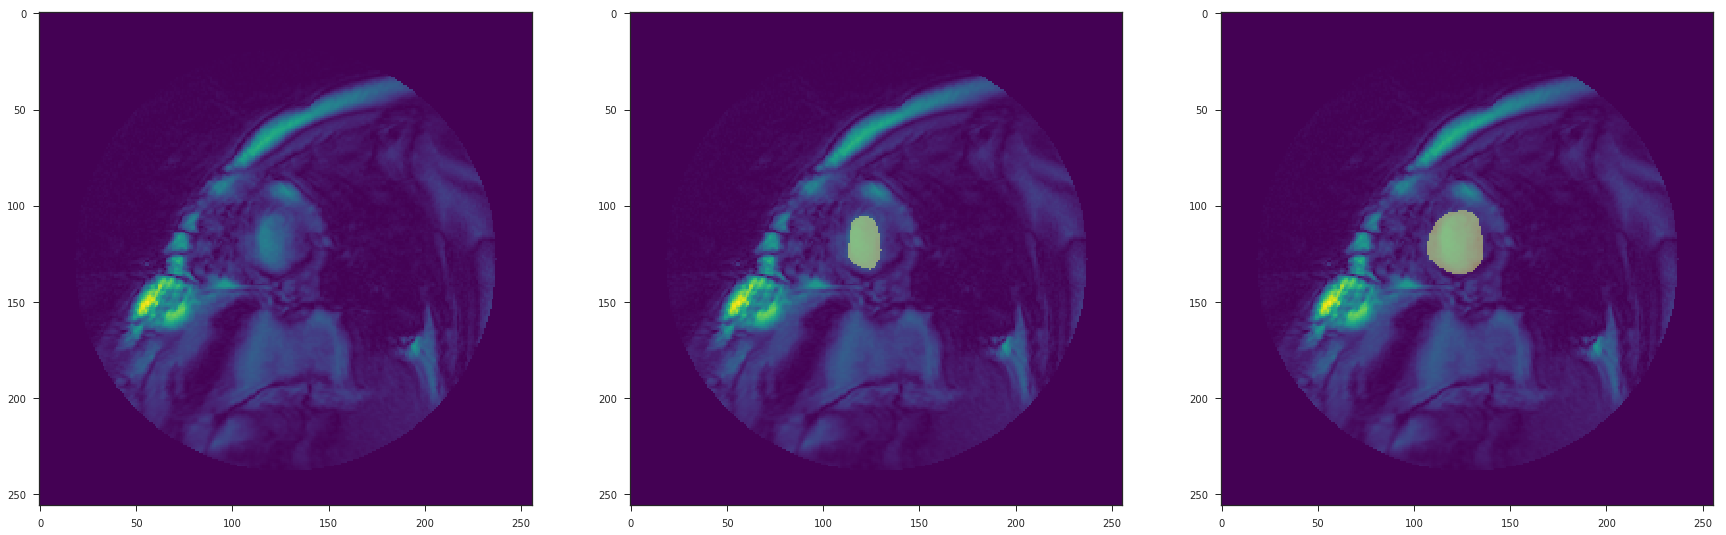

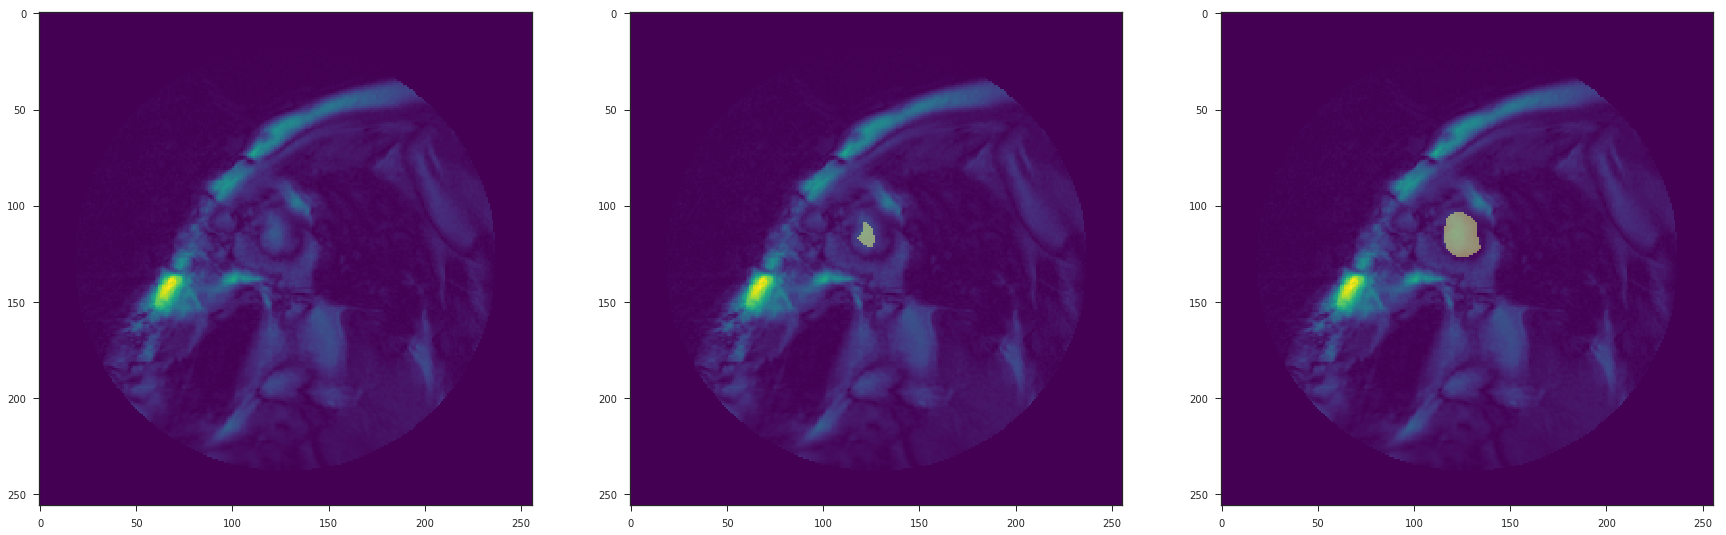

In [55]:
for slice_idx in slice_idxs:
    dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idx)
    show_all_masks(dicom_array, i_contour_array, o_contour_array)

In [56]:
slice_idx=slice_idxs[5]
dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idx)
proposal = i_contour_from_o_contour(dicom_array, o_contour_array)

#### Patient 4

We can see that the low scores for patient 4 is because of shifted o-contours we have. We can try flip and check, but still it's better to ask the reason why might this happen to data provider. We will ignore patient 4 for the rest of the analysis.

In [57]:
patient = patients[-1]

In [58]:
slice_idxs = sorted(extract_all_mask_slices(patient))

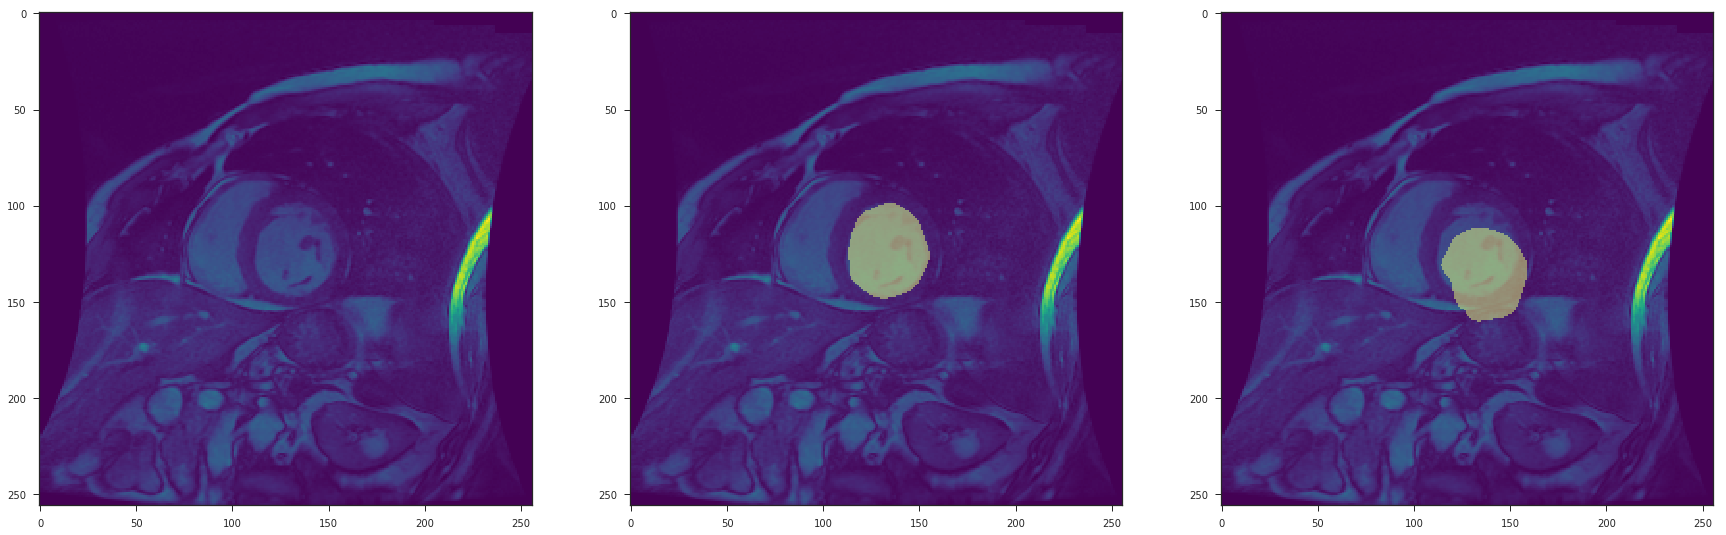

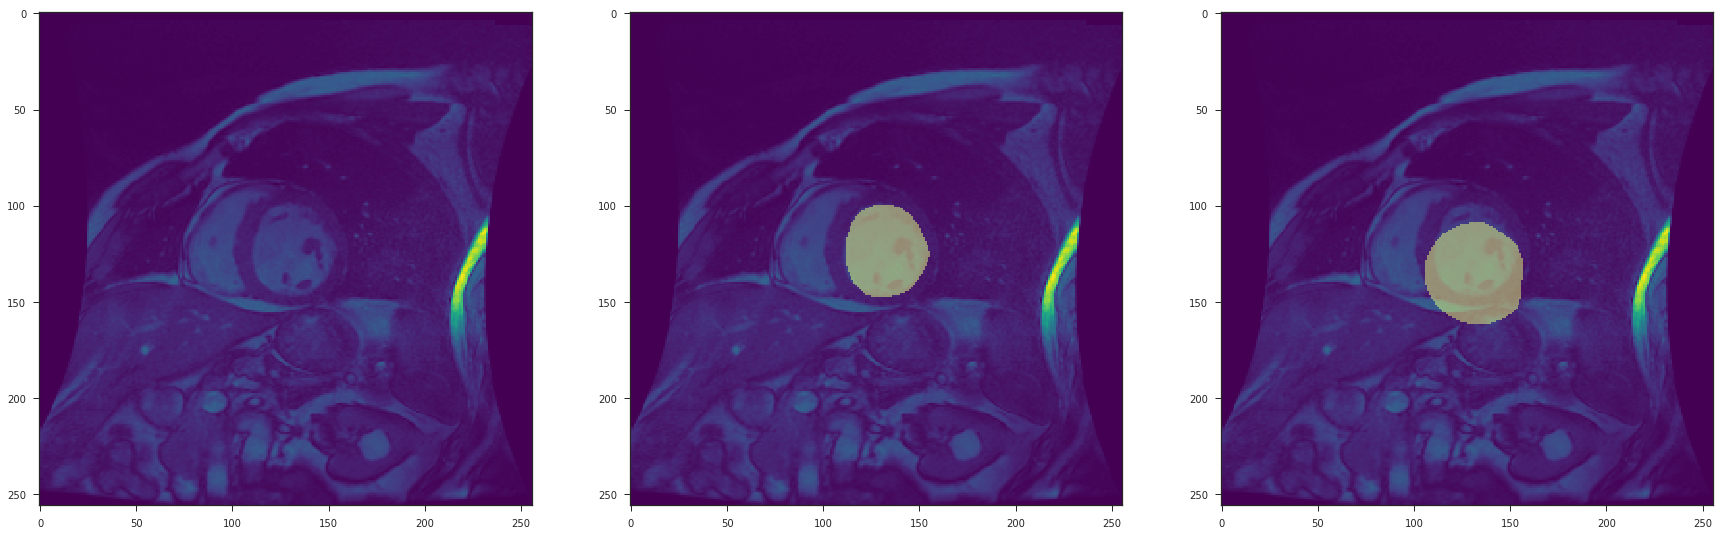

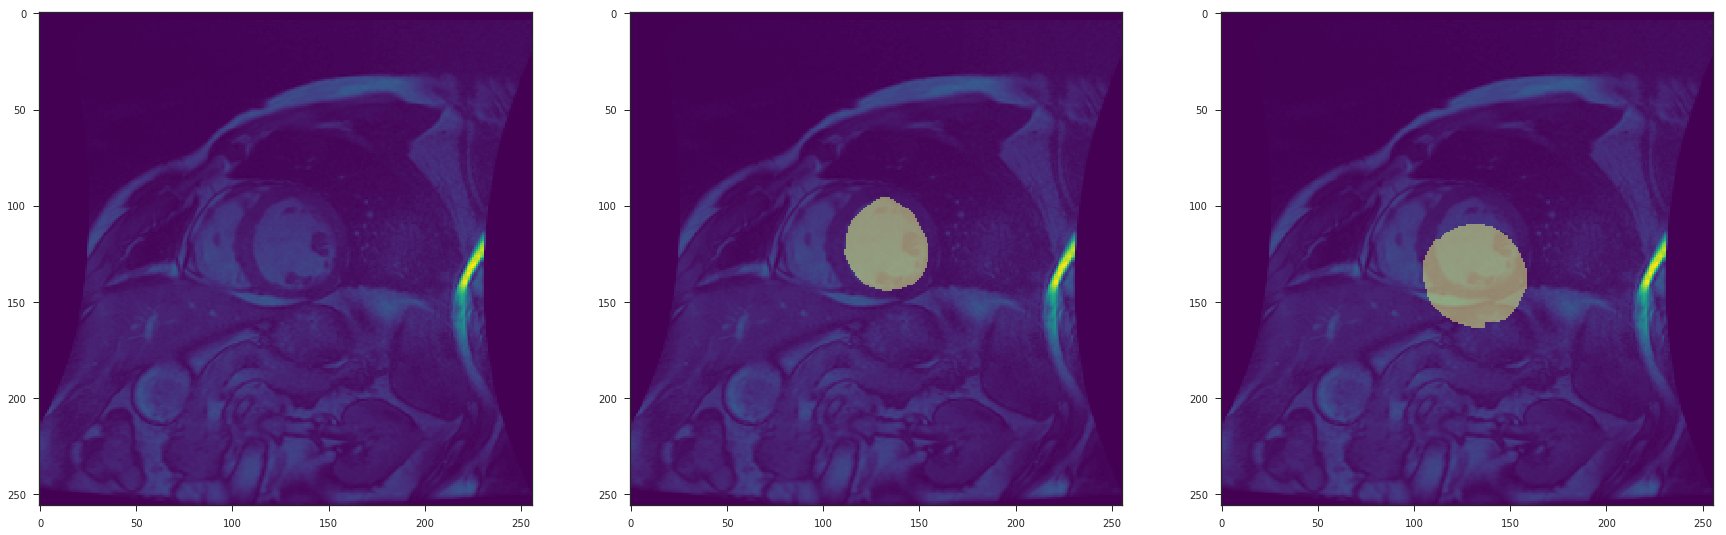

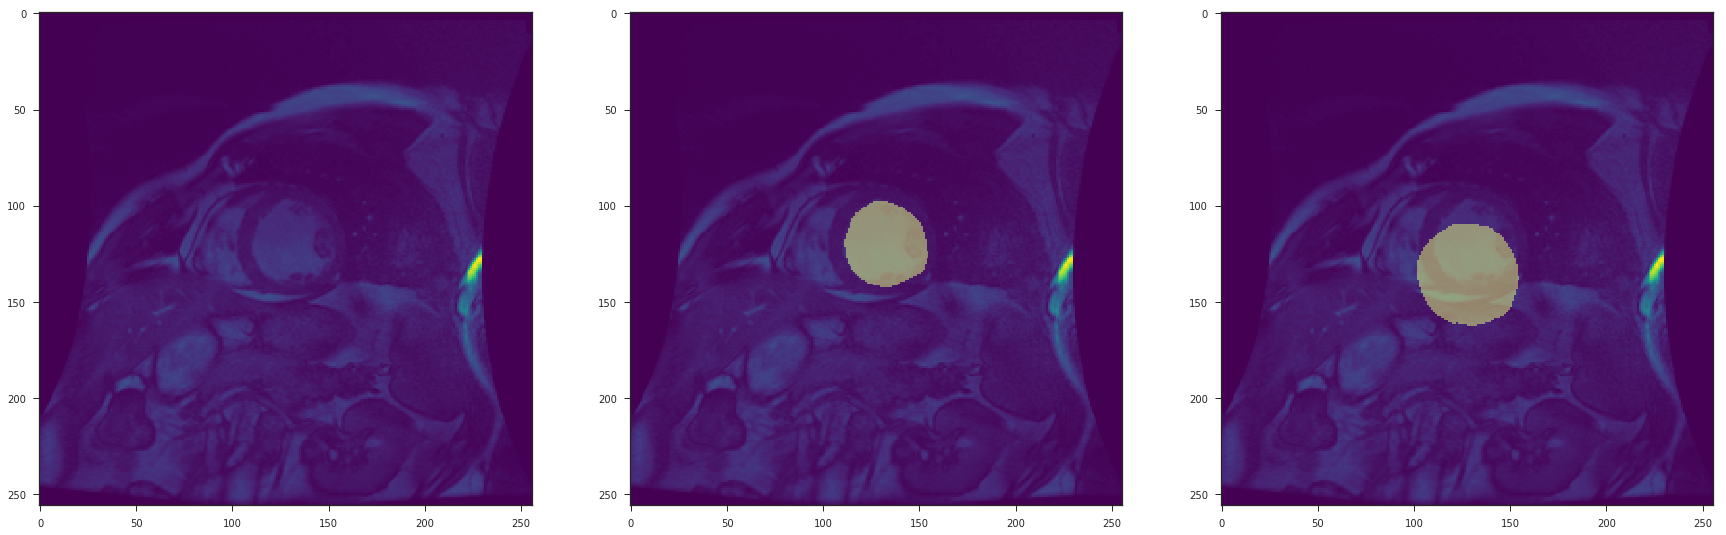

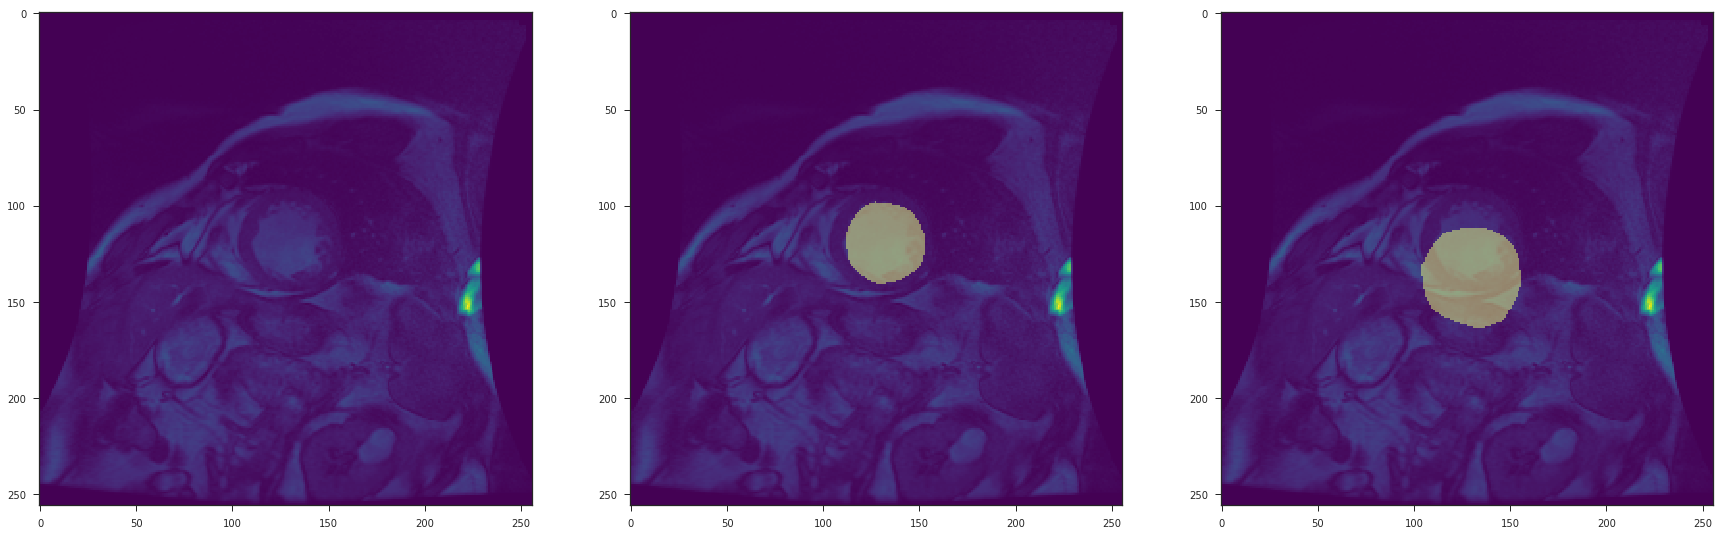

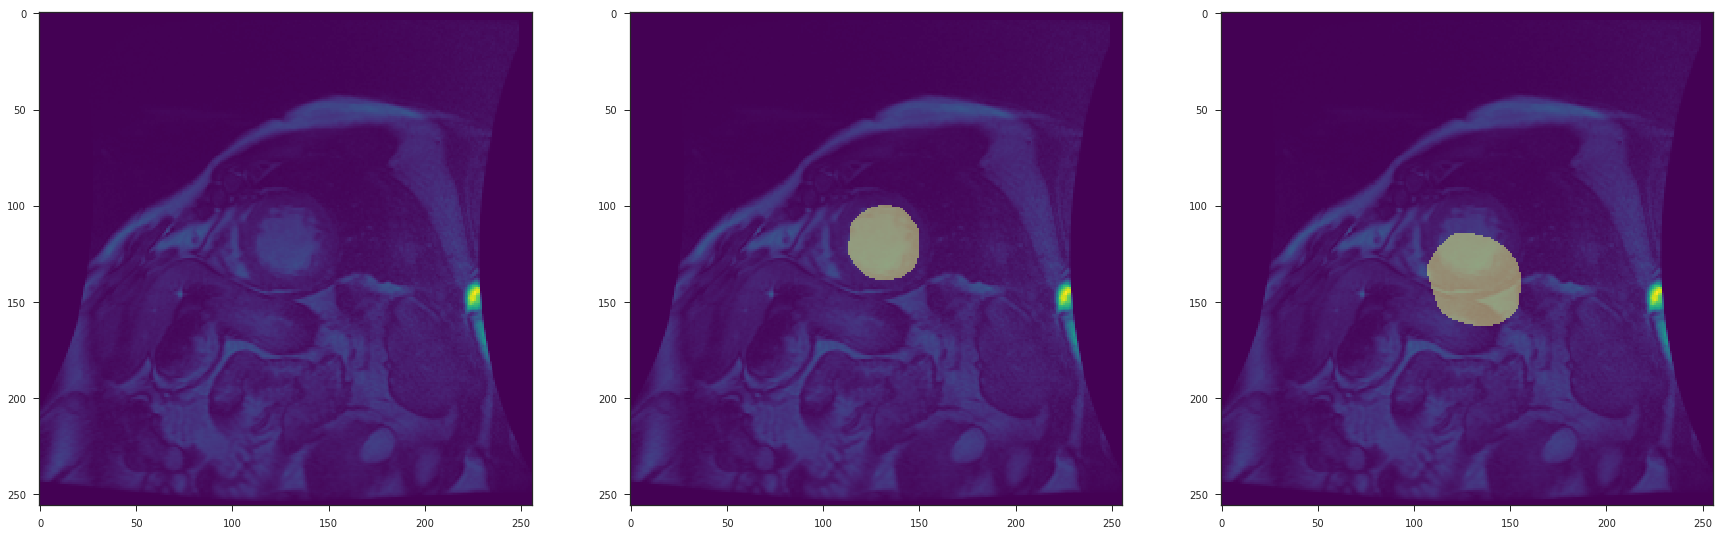

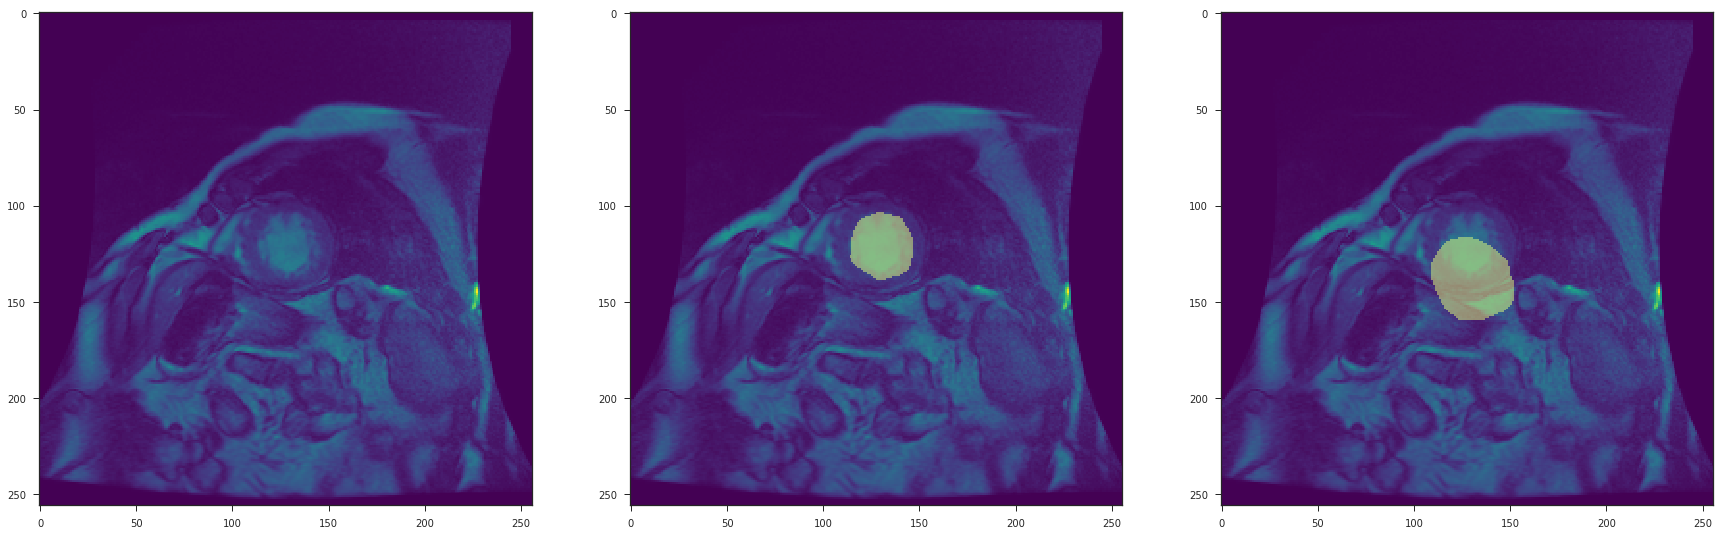

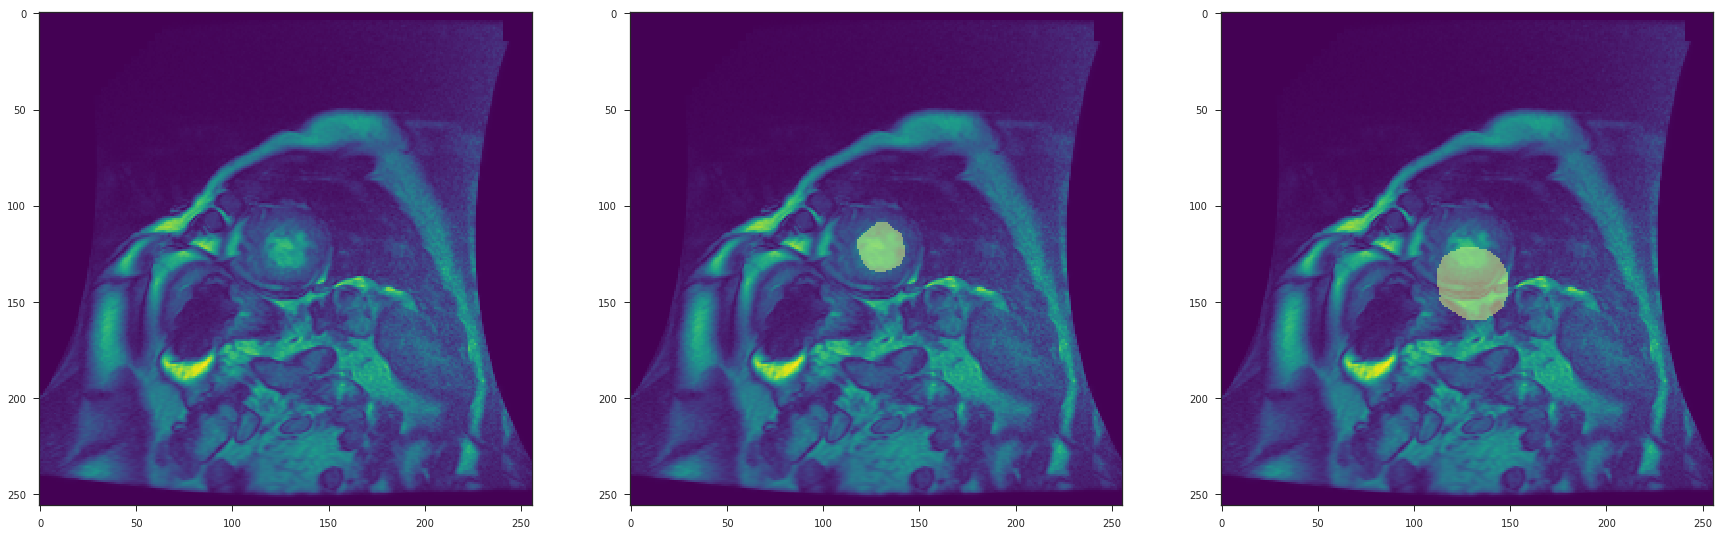

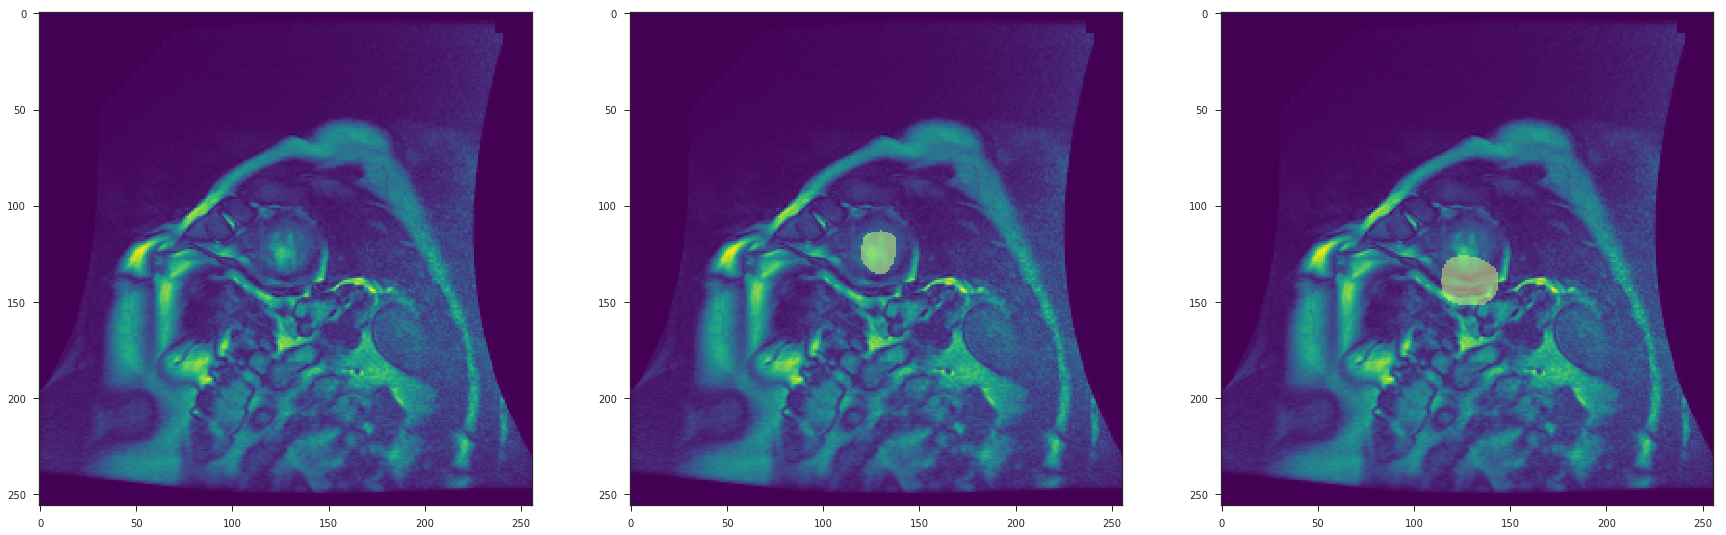

In [59]:
for slice_idx in slice_idxs:
    dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idx)
    show_all_masks(dicom_array, i_contour_array, o_contour_array)

### Plot Densities of ROI for each slice and patient

In [57]:
import warnings
warnings.simplefilter("ignore")

In [58]:
patient_idx = 1
patient = patients[patient_idx]
slice_idxs = sorted(extract_all_mask_slices(patient))

In [59]:
len(slice_idxs)

9

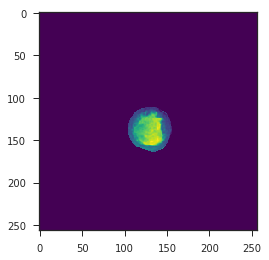

In [60]:
plt.imshow(roi_array)

In [21]:
def plot_roi_densities(patient, slice_idxs, patient_idx=0, save_path=None):
    """
    Plot or save ROI intensity distributions bounded
    by o-contour masks.
    
    Inputs:
        patient (Patient): patient object
        slice_idxs (list): list of indexes for roi slices
        patient_idx (int, str): patient index or name for title and filename
        save_path (str): file destination for saving the figure
    """
    # set subplots and title
    fig,axes = plt.subplots(nrows=len(slice_idxs)//3 + len(slice_idxs)%3, ncols=3,figsize=(15,10))
    fig.suptitle(f'Patient {patient_idx}', fontsize=20)
    # plot for all given slices
    for i,(ax, slice_idx) in enumerate(zip(axes.flat, slice_idxs)):
        # extract numpy arrays for given slices
        dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idx)
        # get roi by bounding the raw image with o-contour
        roi_array = (dicom_array * o_contour_array).astype('int32')
        ax.set_title(f'ROI slice {slice_idx}')
        ax.set_xlabel('pixel intensity')
        # filter for roi and plot density
        sns.distplot(roi_array.flatten()[roi_array.flatten() > 0], bins=50, ax=ax)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path is None:
        fig.show()
    else:
        plt.savefig(save_path)
        plt.close()

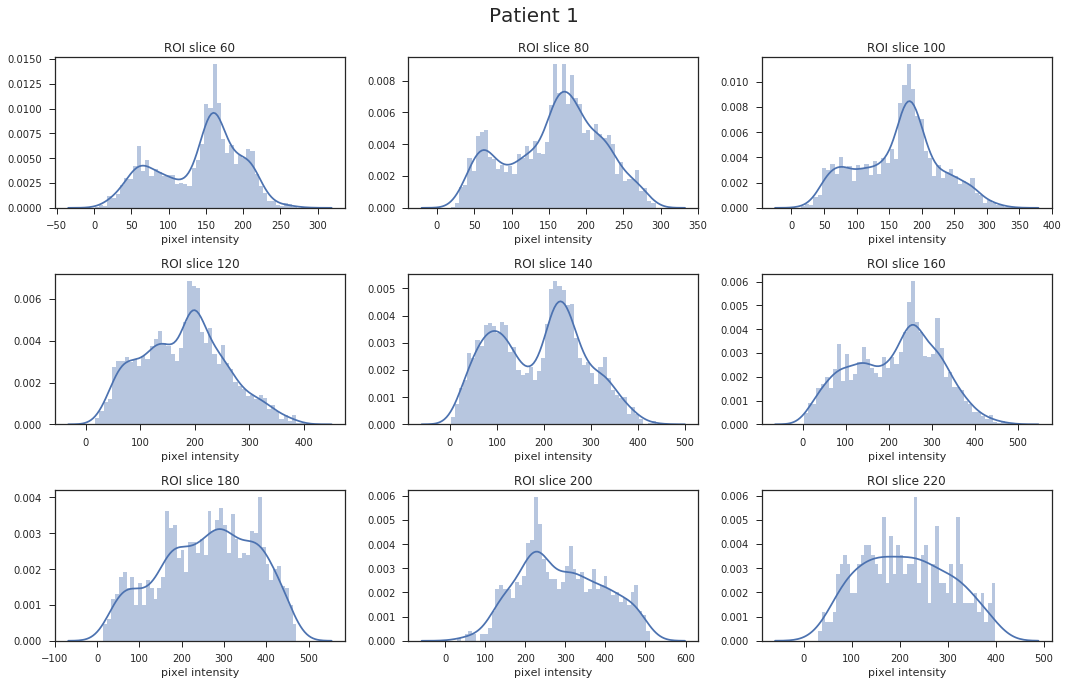

In [91]:
plot_roi_densities(patient, slice_idxs, patient_idx)

In [92]:
# save ROI pixel distributions for each patient/study
for i, patient in enumerate(patients):
    # extract slice idxs that have i-contour and o-contour
    slice_idxs = sorted(extract_all_mask_slices(patient))
    # generate and save roi plots 
    # it's the area bounded by o-contour
    plot_roi_densities(patient, slice_idxs, i,
                       save_path=f"../final_data/images/roi_intensities/patient_{i}")

### Otsu for Adaptive Thresholding

Since we have variance among slices and patients we can't pick a fixed thresholding value. This difference and variability can be seen in ROI pixel distribution plots.

Let's modify the fixed thresholding in `i_contour_from_o_contour` function to have adaptive values for each slice dynamically.

In [129]:
from skimage import filters

In [130]:
patient_idx = 1
patient = patients[patient_idx]
slice_idxs = sorted(extract_all_mask_slices(patient))

In [131]:
dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idxs[0])

In [132]:
def plot_roi_density(dicom_array, o_contour_array, slice_idx=None):
    """
    Plot single ROI density plot from dicom and o-contour
    
    Inputs:
        dicom_array (np.array): raw image
        o_contour_array (np.array): o-contour array
    """
    # get roi by bounding the raw image with o-contour
    roi_array = (dicom_array * o_contour_array).astype('int32')
    # filter for roi and plot density
    sns.distplot(roi_array.flatten()[roi_array.flatten() > 0], bins=50)

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


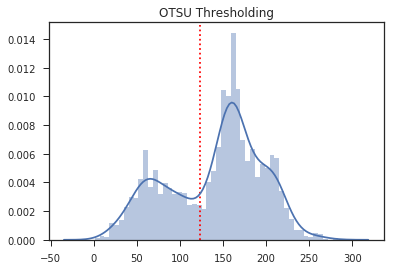

In [133]:
# plot density
plot_roi_density(dicom_array, o_contour_array)
# plot otsu threshold line
roi_array = dicom_array * o_contour_array    
val = filters.threshold_otsu(roi_array[roi_array!=0])
plt.vlines(val, 0, 0.015, colors="red", linestyles=":")
ax = plt.title("OTSU Thresholding")

**Now that we see OTSU is doing a good job at picking thresholds for us we can modify our i-contour generator function**

In [134]:
def i_contour_from_o_contour(dicom_array, o_contour_array, threshold = "auto",
                            kernel_type=0, kernel_sz=3):
    """
    Generate i-contour given a o-contour array
    by employing thresholding and morphological
    operations. Applies closing -> opening -> final proposal
    
    Inputs:
        dicom_array (np.array): Raw DICOM image
        
        o_contour_array (np.array): Boolean mask array
            for o-contour
        
        threshold (int, ): threshold for i-contour
            extraction. 
            if "auto", threshold will be estimated by OTSU
            https://en.wikipedia.org/wiki/Otsu%27s_method
            
        kernel_type (int, list): 0: cv2.MORPH_RECT
                                 1: cv2.MORPH_ELLIPSE
                                 2: cv2.MORPH_CROSS
            If list, it must have 2 elements:
            one for opening, one for closing.
        
        kernel_size (int, list): kernel size for operations
            If list, it must have 2 elements:
            one for opening, one for closing
    Return:
        i_contour_proposal (np.array): Proposed boolean
        mask array for i-contour
    """
    #pdb.set_trace()

    if isinstance(kernel_type, list) & isinstance(kernel_sz, list):
        kernel_type1, kernel_type2 = kernel_type
        kernel_sz1, kernel_sz2 = kernel_sz
        
    elif isinstance(kernel_type, int) & isinstance(kernel_sz, int):
        kernel_type1, kernel_type2 = kernel_type, kernel_type
        kernel_sz1, kernel_sz2 = kernel_sz, kernel_sz
    else:
        raise Exception('kernel_type and kernel_sz must be both int or list')
    
    # generate proposal
    roi_array = dicom_array * o_contour_array    
    if threshold == "auto": 
        threshold = filters.threshold_otsu(roi_array[roi_array != 0])    
    roi_i_contour_proposal = (roi_array > threshold).astype(np.uint8)

    # apply closing
    kernel = cv2.getStructuringElement(KERNEL_TYPE[kernel_type1],
                                       (kernel_sz1, kernel_sz1))
    roi_i_contour_proposal = cv2.morphologyEx(roi_i_contour_proposal,
                                                     cv2.MORPH_CLOSE, kernel)
    # apply opening
    kernel = cv2.getStructuringElement(KERNEL_TYPE[kernel_type2],
                                       (kernel_sz2, kernel_sz2))
    roi_i_contour_proposal = cv2.morphologyEx(roi_i_contour_proposal,
                                                    cv2.MORPH_OPEN, kernel)

    return roi_i_contour_proposal

In [135]:
all_dice_scores = []
all_baseline_scores = []
patient_ids = []

for i, patient in enumerate(patients):
    print(f"Patient {i}")
    # extracting mask slice idxs for patient 
    all_mask_slice_idxs = sorted(extract_all_mask_slices(patient))
    
    dice_scores = []
    baseline_scores = []
    for all_mask_slice_idx in all_mask_slice_idxs:
        # extract slices with all arrays
        dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, all_mask_slice_idx)
        
        # OTSU for adaptive threshold
        
        
        # generate proposal
        proposal = i_contour_from_o_contour(dicom_array=dicom_array,
                                            o_contour_array=o_contour_array,
                                            threshold="auto",
                                            kernel_type=0,
                                            kernel_sz=3
                                           )
        # calculate dice and baseline scores
        dice = round(dice_score(proposal, i_contour_array), 3)
        baseline = round(dice_score(o_contour_array, i_contour_array), 3)
        # print it
        print(f"Slice {all_mask_slice_idx} Dice Score {dice}")
        dice_scores.append(dice)
        baseline_scores.append(baseline)
    # print stats
    print()
    print(f"Dice Mean: {round(np.mean(dice_scores),3)}, Std: {round(np.std(dice_scores),2)}")
    print(f"Baseline Mean: {round(np.mean(baseline_scores),3)}, Std: {round(np.std(baseline_scores),2)}")
    print()
    # collect all 
    all_dice_scores.append(dice_scores)
    all_baseline_scores.append(baseline_scores)
    patient_ids.append([i]*len(dice_scores))

Patient 0
Slice 59 Dice Score 0.953
Slice 79 Dice Score 0.951
Slice 99 Dice Score 0.886
Slice 119 Dice Score 0.879
Slice 139 Dice Score 0.845
Slice 159 Dice Score 0.859
Slice 179 Dice Score 0.871
Slice 199 Dice Score 0.872
Slice 219 Dice Score 0.64

Dice Mean: 0.862, Std: 0.09
Baseline Mean: 0.768, Std: 0.02

Patient 1
Slice 60 Dice Score 0.946
Slice 80 Dice Score 0.934
Slice 100 Dice Score 0.917
Slice 120 Dice Score 0.842
Slice 140 Dice Score 0.872
Slice 160 Dice Score 0.862
Slice 180 Dice Score 0.855
Slice 200 Dice Score 0.889
Slice 220 Dice Score 0.607

Dice Mean: 0.858, Std: 0.1
Baseline Mean: 0.722, Std: 0.14

Patient 2
Slice 20 Dice Score 0.937
Slice 40 Dice Score 0.881
Slice 60 Dice Score 0.839
Slice 80 Dice Score 0.855
Slice 100 Dice Score 0.873
Slice 120 Dice Score 0.857
Slice 140 Dice Score 0.862
Slice 160 Dice Score 0.875
Slice 180 Dice Score 0.878
Slice 200 Dice Score 0.833

Dice Mean: 0.869, Std: 0.03
Baseline Mean: 0.768, Std: 0.05

Patient 3
Slice 40 Dice Score 0.965
Sli

In [136]:
# prepare summary dataframe for plotting
n = len([y for x in all_baseline_scores for y in x])
summary = pd.DataFrame({"scores":np.hstack(all_dice_scores + all_baseline_scores),
              "id":np.hstack(patient_ids + patient_ids),
              "method":n*["otsu"] + n*["baseline"]})

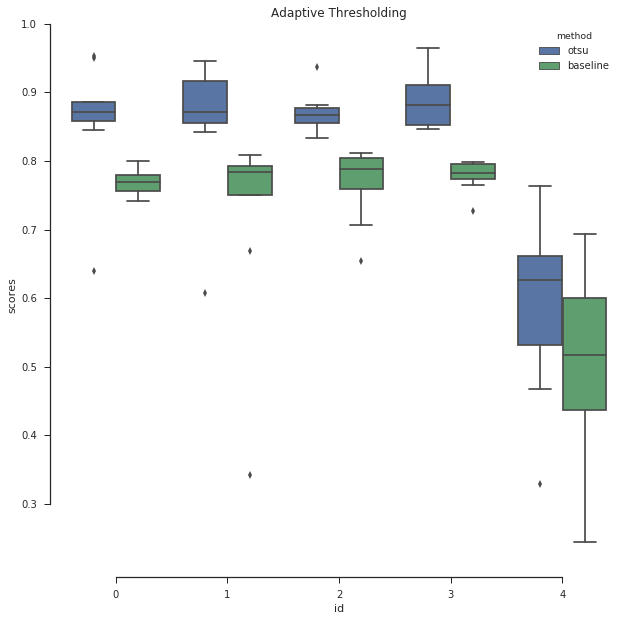

In [137]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('Patient Id')
plt.ylabel('Dice Score')

sns.set(style="ticks")
sns.boxplot(x="id", y="scores", hue="method", data=summary, ax=ax)
sns.despine(offset=10, trim=True)
t = plt.title("Adaptive Thresholding")

In [138]:
heuristic2_res = summary

**OTSU increased our mean dice score by 2.6% and std decrease by 2.7 points. Still results are not good enough since we don't have bimodal distribution at each slice. This can be seen in ROI pixel density plots.**

In [141]:
h1 = heuristic1_res.groupby('method')['scores'].agg({'mean':np.mean, 'std':np.std})

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [142]:
h2 = heuristic2_res.groupby('method')['scores'].agg({'mean':np.mean, 'std':np.std})

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [144]:
pd.concat([h1, h2])

,mean,std
method,,
baseline,0.707848,0.144136
heuristic,0.790543,0.167922
baseline,0.707848,0.144136
otsu,0.816391,0.140014


### Method: Edge-based 

In [126]:
from skimage.feature import canny
from scipy import ndimage as ndi

In [112]:
patient_idx = 1
patient = patients[patient_idx]
slice_idxs = sorted(extract_all_mask_slices(patient))

dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idxs[0])

roi_array = dicom_array * o_contour_array    

In [124]:
def min_max_scale(array):
    return (array - array.min())/array.max()

In [127]:
edges = canny(min_max_scale(roi_array))

In [130]:
filled = ndi.binary_fill_holes(edges)

In [132]:
from skimage.filters import sobel

In [133]:
elevation_map = sobel(roi_array)

(array([6.3749e+04, 9.1400e+02, 3.9800e+02, 2.0200e+02, 1.2100e+02,
        8.3000e+01, 5.4000e+01, 1.0000e+01, 2.0000e+00, 3.0000e+00]),
 array([0.        , 0.00037066, 0.00074131, 0.00111197, 0.00148262,
        0.00185328, 0.00222394, 0.00259459, 0.00296525, 0.0033359 ,
        0.00370656]),
 <a list of 10 Patch objects>)

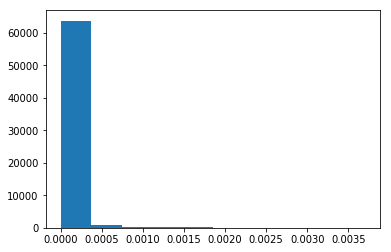

In [140]:
plt.hist(elevation_map.flatten())

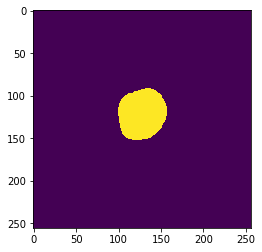

In [147]:
plt.imshow(roi_array>0)

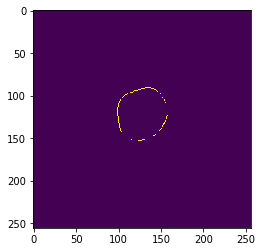

In [150]:
plt.imshow(np.uint8(roi_array>0) - np.uint8(elevation_map > 0.001))

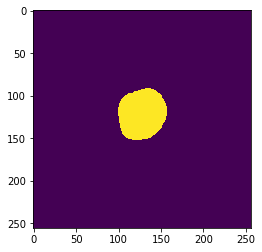

In [154]:
plt.imshow(np.uint8(roi_array>0))

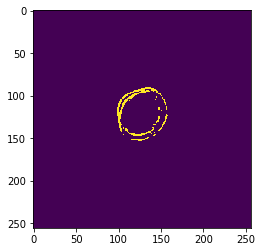

In [152]:
plt.imshow(np.uint8(elevation_map > 0.001))

### Method: Watershed Algorithm

Good for connected component separation

In [157]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

In [158]:
patient_idx = 1
patient = patients[patient_idx]
slice_idxs = sorted(extract_all_mask_slices(patient))

dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idxs[0])

roi_array = dicom_array * o_contour_array    

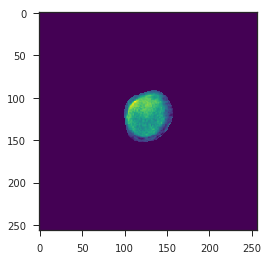

In [251]:
plt.imshow(roi_array)

In [264]:
img = cv2.cvtColor(np.uint8(roi_array), cv2.COLOR_GRAY2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [265]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

In [276]:
sure_bg = np.uint8(gray > 0)

In [287]:
gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [282]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [283]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [284]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

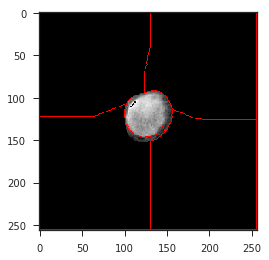

In [285]:
plt.imshow(img)

### Method: Region Growing

We know i-contour is always smaller than o-contour. 

Very slow algorithm, still depends on a fixed value: epsilon = diff of neighboring pixels.

In [52]:
patient_idx = 1
patient = patients[patient_idx]
slice_idxs = sorted(extract_all_mask_slices(patient))

dicom_array, i_contour_array, o_contour_array = extract_patient_arrays(patient, slice_idxs[0])

roi_array = dicom_array * o_contour_array    

In [53]:
img = cv2.cvtColor(np.uint8(roi_array), cv2.COLOR_GRAY2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

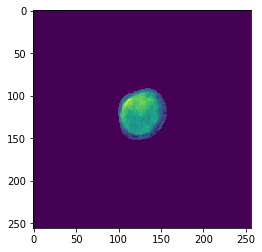

In [54]:
plt.imshow(roi_array)

In [94]:
class Queue:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items==[]

    def enque(self,item):
        self.items.insert(0,item)

    def deque(self):
        return self.items.pop()

    def qsize(self):
        return len(self.items)
    
    def isInside(self, item):
        return (item in self.items)
        

from PIL import Image


def regiongrow(image,epsilon,start_point):

    Q = Queue()
    s = []
    
    x = start_point[0]
    y = start_point[1]
    
    #image = image.convert("L")
    Q.enque((x,y))

    
    while not Q.isEmpty():

        t = Q.deque()
        x = t[0]
        y = t[1]
        
        if x < image.shape[0]-1 and \
           abs(image[x + 1 , y] - image[x , y]) <= epsilon :

            if not Q.isInside( (x + 1 , y) ) and not (x + 1 , y) in s:
                Q.enque( (x + 1 , y) )

                
        if x > 0 and \
           abs(image[x - 1, y] - image[x , y]) <= epsilon:

            if not Q.isInside( (x - 1 , y) ) and not (x - 1 , y) in s:
                Q.enque( (x - 1 , y) )

                     
        if y < (image.shape[1] - 1) and \
           abs(image[x , y + 1] - image[x , y]) <= epsilon:

            if not Q.isInside( (x, y + 1) ) and not (x , y + 1) in s:
                Q.enque( (x , y + 1) )

                    
        if y > 0 and \
           abs(image[x , y - 1] - image[x , y]) <= epsilon:

            if not Q.isInside( (x , y - 1) ) and not (x , y - 1) in s:
                Q.enque( (x , y - 1) )


        if t not in s:
            s.append( t )

            
    return s

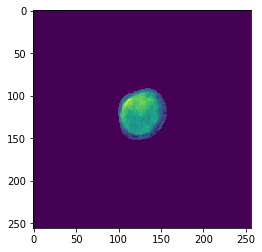

In [104]:
plt.imshow(roi_array)

In [109]:
s = regiongrow(gray, 50, (125,125))

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in ubyte_scalars
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in ubyte_scalars
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in ubyte_scalars
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in ubyte_scalars


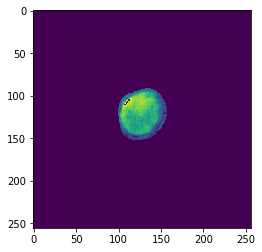

In [90]:
plt.imshow(gray)

In [86]:
plt.imshow(region_growing(gray, (125,125)))

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in ubyte_scalars


KeyboardInterrupt: 